# Given an ALFALFA-like survey, which NASA-Sloan Atlas sources should be detected?

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord

from pathlib import Path

PATH = Path('..').resolve()
%matplotlib inline

In [115]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [7]:
nsa = Table.read(f'{PATH}/data/nsa_v0_1_2.fits')

a40 = pd.read_csv(f'{PATH}/../alfalfa-convnets/data/a100.code12.tab1.180315.csv')

In [4]:
a40.head()

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
0,105367,........,0.00167,5.44333,0.00333,5.44250,11983,274,39,281,1.14,0.08,8.1,1.91,166.0,2.3,9.87,0.05,1
1,333313,........,0.00375,24.90889,359.99750,24.90750,11181,313,20,333,1.80,0.09,11.3,2.02,154.8,2.3,10.01,0.05,1
2,331060,478-009b,0.01042,23.08472,0.01417,23.08750,4463,160,4,184,1.96,0.07,14.7,2.35,50.6,10.4,9.07,0.18,1
3,331061,456-013.,0.01042,15.87222,0.00875,15.88167,6007,260,45,268,1.13,0.09,6.5,2.40,85.2,2.4,9.29,0.06,1
4,104570,........,0.00667,32.70834,0.00500,32.71028,10614,245,6,250,0.86,0.07,6.6,1.86,147.0,2.3,9.64,0.06,1


In [9]:
nsa.columns

<TableColumns names=('IAUNAME','SUBDIR','RA','DEC','ISDSS','INED','ISIXDF','IALFALFA','IZCAT','ITWODF','MAG','Z','ZSRC','SIZE','RUN','CAMCOL','FIELD','RERUN','XPOS','YPOS','ZLG','ZDIST','ZDIST_ERR','NSAID','NMGY','NMGY_IVAR','OK','RNMGY','ABSMAG','AMIVAR','EXTINCTION','KCORRECT','KCOEFF','MTOL','B300','B1000','METS','MASS','XCEN','YCEN','NPROF','PROFMEAN','PROFMEAN_IVAR','QSTOKES','USTOKES','BASTOKES','PHISTOKES','PETROFLUX','PETROFLUX_IVAR','FIBERFLUX','FIBERFLUX_IVAR','BA50','PHI50','BA90','PHI90','SERSICFLUX','SERSICFLUX_IVAR','SERSIC_N','SERSIC_BA','SERSIC_PHI','ASYMMETRY','CLUMPY','DFLAGS','AID','PID','DVERSION','PROFTHETA','PETROTHETA','PETROTH50','PETROTH90','SERSIC_TH50','OBJNO','PLATE','FIBERID','MJD','COEFF','VDISP','D4000','D4000ERR','FA','FAERR','S2FLUX','S2FLUXERR','S2EW','S2EWERR','S2VMEAS','S2VMERR','S2RATIO','HAFLUX','HAFLUXERR','HAEW','HAEWERR','HAVMEAS','HAVMERR','N2FLUX','N2FLUXERR','N2EW','N2EWERR','N2VMEAS','N2VMERR','HBFLUX','HBFLUXERR','HBEW','HBEWERR','HBVMEAS',

In [63]:
# get a bunch of columns -> pandas

ra = nsa['RA'].data
dec = nsa['DEC'].data

idx_alfalfa = nsa['IALFALFA'].data

abs_mags = nsa['ABSMAG'].data
zs = nsa['Z'].data

# log_sfr_300 = np.log10(nsa['B300'].data)
# log_sfr_1000 = np.log10(nsa['B1000'].data)
# log_Mstar = np.log10(nsa['MASS'].data)

# log_HAEW = np.log10(nsa['HAEW'].data)
# log_O3EW = np.log10(nsa['O3EW'].data)
# log_O2EW = np.log10(nsa['O2EW'].data)
# log_N2EW = np.log10(nsa['N2EW'].data)

# log_d4000 = np.log10(nsa['D4000'].data)

sersic = nsa['SERSIC_N'].data

# basically only photometry
df = pd.DataFrame(
    {'ra' : ra,
     'dec': dec,
     'Mag_u': abs_mags[:, 0],
     'Mag_g': abs_mags[:, 1],
     'Mag_r': abs_mags[:, 2],
     'Mag_i': abs_mags[:, 3],
     'Mag_z': abs_mags[:, 4],
     'Mag_F': abs_mags[:, 5],
     'Mag_N': abs_mags[:, 6],
     'z': zs,
#      'log_sfr_300': log_sfr_300,
#      'log_sfr_1000': log_sfr_1000,
#      'log_Mstar': log_Mstar,
#      'log_HAEW': log_HAEW,
#      'log_O3EW': log_O3EW,
#      'log_O2EW': log_O2EW,
#      'log_N2EW': log_N2EW,
#      'log_d4000': log_d4000,
     'sersic': sersic,
     'idx_alfalfa': idx_alfalfa,
    }
).apply(lambda x: np.array(x).byteswap().newbyteorder()) # pandas forces byte ordering


df['alf'] = (df.idx_alfalfa > 0)

In [65]:
(df['alf']).sum()

718

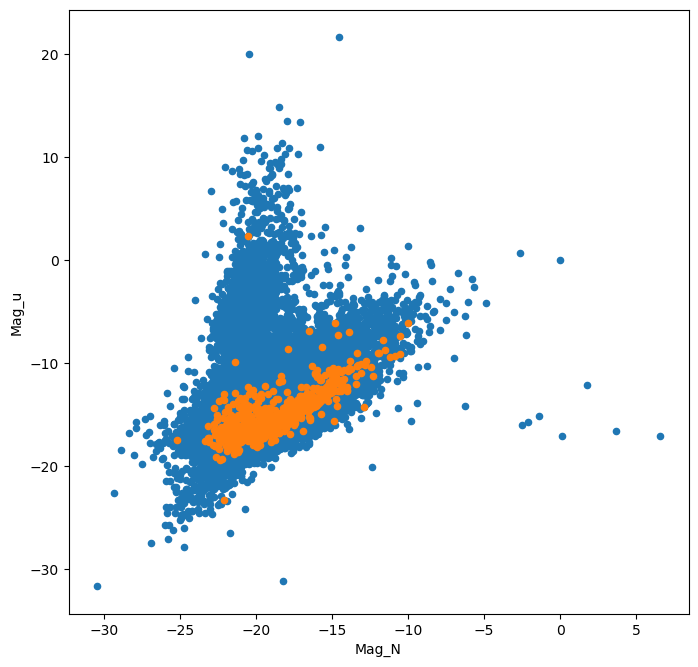

In [67]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot()
df.plot.scatter(x='Mag_N', y='Mag_u', ax=ax, c='C0')
df[df.alf].plot.scatter(x='Mag_N', y='Mag_u', ax=ax, c='C1')

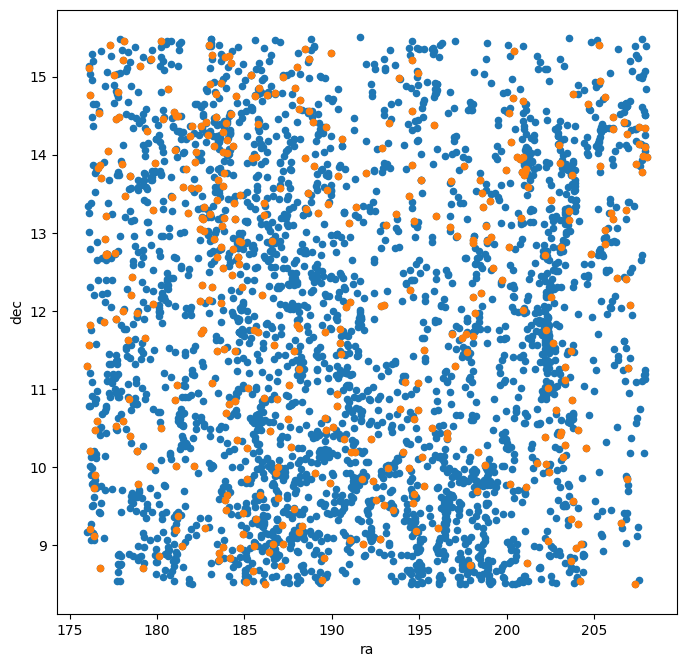

In [86]:
fig = plt.figure(figsize=(8,8), dpi=100)
ax = fig.add_subplot()

# very narrow range
in_range = (176 < df.ra) & (df.ra < 208) & (8.5 < df.dec) & (df.dec < 15.5) & (df.z > 0.002)

df[in_range].plot.scatter(x='ra', y='dec', ax=ax, c='C0')
df[in_range & df.alf].plot.scatter(x='ra', y='dec', ax=ax, c='C1')

In [87]:
df[in_range].alf.sum(), (~df[in_range].alf).sum()

(400, 2974)

# Try with mini version of data

In [88]:
lildf = df[in_range].copy()

In [89]:
lildf.columns

Index(['ra', 'dec', 'Mag_u', 'Mag_g', 'Mag_r', 'Mag_i', 'Mag_z', 'Mag_F',
       'Mag_N', 'z', 'sersic', 'idx_alfalfa', 'alf'],
      dtype='object')

In [90]:
cols = ['Mag_u', 'Mag_g', 'Mag_r', 'Mag_i', 'Mag_z', 'Mag_F', 'Mag_N', 'z', 'sersic',]

In [92]:
X = lildf[cols]
y = lildf['alf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Random Forest

In [192]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
score = rf.score(X_test, y_test)
score

0.9158767772511849

## Gradient Boosted Trees

In [137]:
gb = GradientBoostingClassifier(learning_rate=0.15, n_estimators=100)
gb.fit(X_train, y_train)

pred = gb.predict(X_test)
score = gb.score(X_test, y_test)
score

0.9123222748815166

## xgboost

In [138]:
# ! pip install xgboost

     |████████████████████████████████| 142.8MB 78kB/s s eta 0:00:01


In [139]:
from xgboost import XGBClassifier, XGBRFClassifier

In [174]:
xgbc = XGBClassifier(max_depth=6, learning_rate=0.08, n_estimators=120)

xgbc.fit(X_train, y_train)

pred = xgbc.predict(X_test)
score = xgbc.score(X_test, y_test)
score

0.9135071090047393

In [190]:
xgbrf = XGBRFClassifier(max_depth=10, learning_rate=0.5, n_estimators=150)

xgbrf.fit(X_train, y_train)

pred = xgbrf.predict(X_test)
score = xgbrf.score(X_test, y_test)
score

0.9135071090047393